In [30]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [31]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [32]:
len(words)

32033

In [33]:
# Vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
#s = tuple(enumerate(chars))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [34]:
# Build the dataset
block_size = 3 # Context length: how many characters do we take to predict the next one.

def build_dataset(words):
    x, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr,  ytr  = build_dataset(words[:n1])   # 80% - Training Split
xdev, ydev = build_dataset(words[n1:n2]) # 10% - Dev/Validation Split
xte,  yte  = build_dataset(words[n2:])   # 10% - Test Split



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [35]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [36]:
# MLP

n_embd = 10     # The dimensionality of the character embedding vectors
n_hidden = 64  # The number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
c = torch.randn((vocab_size, n_embd),             generator=g)

# Layer 1
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/((n_embd * block_size)**0.5))
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

# Layer 2
w2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# Batch Norm Parameters
bngain = torch.randn(1, n_hidden) * 0.1 + 1.0
bnbias = torch.randn(1, n_hidden) * 0.1


parameters = [c, w1, b1, w2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [37]:
batch_size = 32
n = batch_size

# Mini batch construct
ix = torch.randint(0, xtr.shape[0], (batch_size,), generator=g)
xb, yb = xtr[ix], ytr[ix] # Batch x, y

In [38]:
# Forward Pass

emb = c[xb]                           # embade the char into vectors - emb.shape #-- [32, 3, 2]
embcat = emb.view(emb.shape[0], -1)   # Concatenate the vectors - Same as (emb.view(-1, 30))

#linear Layer
hprebn = embcat @ w1 + b1            #(gets deducted by next two lines)   # hidden layer pre-activation

# Batch Norm Layer
#------------------------------------------------------------------------------
bnmeani =  1/n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#------------------------------------------------------------------------------

# Non-linearity
h = torch.tanh(hpreact)               # hidden layer h.shape #--[32, 100]
logits = h @ w2 + b2                  # logits.shape # -- [32, 27]

# Cross entropy loss same as - loss = F.cross_entropy(logits, yb)

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), yb].mean()


# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3536, grad_fn=<NegBackward0>)

In [87]:
bndiff2.shape

torch.Size([32, 64])

In [102]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), yb] = -1.0/n
dprobs= (1/probs) * dlogprobs                            # d(log(x))/dx = 1/x
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts                           # d(e^x) = e^x => norm_logits.exp() ==> counts
dlogits  = dnorm_logits.clone()
dlogits_max = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_max
dh = dlogits @ w2.T
dw2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = dh * (1-h**2)
dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
dbnraw = dhpreact * bngain
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2*bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = - (torch.ones_like(dhprebn) * dbndiff).sum(0)
dhprebn += 1/n * torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ w1.T
dw1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dc = torch.zeros_like(c)
for k in range(xb.shape[0]):
    for j in range(xb.shape[1]):
        ix = xb[k, j]
        dc[ix] += demb[k,j]
#emb = c[xb]  
# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogits_max, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('w2', dw2, w2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('w1', dw1, w1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('c', dc, c)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [104]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3535518646240234 diff: 0.0


In [106]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits, 1)
dlogits[range(n), yb] -= 1 
dlogits /= n
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


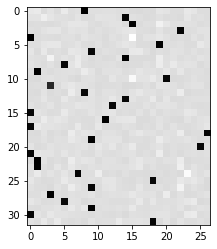

In [107]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [109]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [110]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10
